In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
# from dataprep.eda import plot, plot_correlation, plot_missing, create_report
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import itertools
import warnings
warnings.filterwarnings('ignore')

In [2]:
# tỉ lệ 8:2
df = pd.read_csv('F:/hk2 nam3/nhi/is403/IS403_O21_04/Dataset/DXG Historical Data 1_6.csv')
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df[::-1]

df = df.reset_index(drop=True) # Reset the index

In [3]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
train_data = df[:train_size]
test_data = df[train_size:]

In [4]:
test_data.shape

(480, 1)

In [5]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])

In [6]:
final_model = SimpleExpSmoothing(x_train).fit(optimized=True)
y_pred = final_model.forecast(480)

In [7]:
# 6. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data2 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data3 = pd.RangeIndex(start=last_index+61, stop=last_index+90, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

y_next_90_days = final_model.forecast(len(x_next_90_days))
y_next_90_days



array([1116.99999999, 1116.99999999, 1116.99999999, 1116.99999999,
       1116.99999999, 1116.99999999, 1116.99999999, 1116.99999999,
       1116.99999999, 1116.99999999, 1116.99999999, 1116.99999999,
       1116.99999999, 1116.99999999, 1116.99999999, 1116.99999999,
       1116.99999999, 1116.99999999, 1116.99999999, 1116.99999999,
       1116.99999999, 1116.99999999, 1116.99999999, 1116.99999999,
       1116.99999999, 1116.99999999, 1116.99999999, 1116.99999999,
       1116.99999999, 1116.99999999, 1116.99999999, 1116.99999999,
       1116.99999999, 1116.99999999, 1116.99999999, 1116.99999999,
       1116.99999999, 1116.99999999, 1116.99999999, 1116.99999999,
       1116.99999999, 1116.99999999, 1116.99999999, 1116.99999999,
       1116.99999999, 1116.99999999, 1116.99999999, 1116.99999999,
       1116.99999999, 1116.99999999, 1116.99999999, 1116.99999999,
       1116.99999999, 1116.99999999, 1116.99999999, 1116.99999999,
       1116.99999999, 1116.99999999, 1116.99999999, 1116.99999

In [8]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 15515.395833348235
RMSE: 16053.366799406776
MAPE: 0.9283884867738882


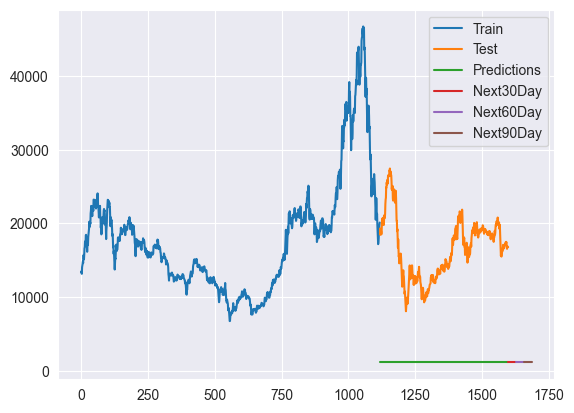

In [9]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data1,y_next_90_days[0:30])
plt.plot(last_data2,y_next_90_days[31:60])
plt.plot(last_data3,y_next_90_days[61:90])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

In [10]:
def plot_model(train, test, y_pred, title):
  mae = mean_absolute_error(test, y_pred)
  train.plot(figsize=(15, 4), legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae, 2)}")
  test.plot(legend=True, label="TEST")
  y_pred.plot(legend=True, label="PREDICTION")
  plt.show()

def des_optimizer(train, test, alphas, betas, trend, step):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend=trend).fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
    return best_alpha, best_beta, best_mae


alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)
best_alpha, best_beta, best_mae = des_optimizer(x_train, x_test, alphas, betas, trend='add', step=480)
final_model = ExponentialSmoothing(x_train, trend='add').fit(smoothing_level=best_alpha, smoothing_slope=best_beta)
y_pred = final_model.forecast(480)

In [11]:
# 6. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data2 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data3 = pd.RangeIndex(start=last_index+61, stop=last_index+90, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

y_next_90_days = final_model.forecast(len(x_next_90_days))
y_next_90_days



array([1118., 1119., 1120., 1121., 1122., 1123., 1124., 1125., 1126.,
       1127., 1128., 1129., 1130., 1131., 1132., 1133., 1134., 1135.,
       1136., 1137., 1138., 1139., 1140., 1141., 1142., 1143., 1144.,
       1145., 1146., 1147., 1148., 1149., 1150., 1151., 1152., 1153.,
       1154., 1155., 1156., 1157., 1158., 1159., 1160., 1161., 1162.,
       1163., 1164., 1165., 1166., 1167., 1168., 1169., 1170., 1171.,
       1172., 1173., 1174., 1175., 1176., 1177., 1178., 1179., 1180.,
       1181., 1182., 1183., 1184., 1185., 1186., 1187., 1188., 1189.,
       1190., 1191., 1192., 1193., 1194., 1195., 1196., 1197., 1198.,
       1199., 1200., 1201., 1202., 1203., 1204., 1205., 1206., 1207.])

In [12]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 15274.895833333334
RMSE: 15818.775048445861
MAPE: 0.9135163731097972


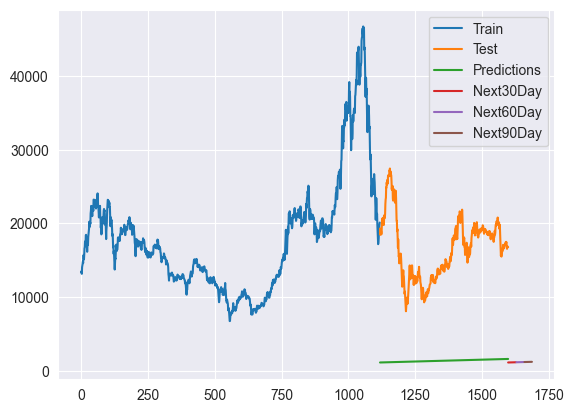

In [13]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data1,y_next_90_days[0:30])
plt.plot(last_data2,y_next_90_days[31:60])
plt.plot(last_data3,y_next_90_days[61:90])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

In [14]:
def tes_optimizer(train, test, abg, trend, seasonal, seasonal_periods, step):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        if np.isnan(y_pred).any():
            continue  # Skip this combination if y_pred contains NaN values
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae

    return best_alpha, best_beta, best_gamma, best_mae

alphas = betas = gammas = np.arange(0.10, 1, 0.10)
abg = list(itertools.product(alphas, betas, gammas))
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(x_train, x_test, abg=abg, trend='add', seasonal='add', seasonal_periods=12, step=480)
final_model = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=12).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
y_pred = final_model.forecast(480)



In [15]:
# 6. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data2 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data3 = pd.RangeIndex(start=last_index+61, stop=last_index+90, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

y_next_90_days = final_model.forecast(len(x_next_90_days))
y_next_90_days



array([ 16483.64593953,  16348.61628407,  16025.80708499,  15409.39928196,
        14871.10051942,  14469.06908331,  14319.67658055,  14068.4713548 ,
        14163.54468534,  14308.5532113 ,  14753.51670013,  13399.15775586,
        12511.62151451,  12376.59185905,  12053.78265997,  11437.37485694,
        10899.0760944 ,  10497.04465829,  10347.65215553,  10096.44692978,
        10191.52026032,  10336.52878628,  10781.49227511,   9427.13333084,
         8539.59708949,   8404.56743403,   8081.75823495,   7465.35043192,
         6927.05166938,   6525.02023327,   6375.62773051,   6124.42250476,
         6219.4958353 ,   6364.50436126,   6809.46785009,   5455.10890582,
         4567.57266447,   4432.54300901,   4109.73380993,   3493.3260069 ,
         2955.02724436,   2552.99580825,   2403.60330549,   2152.39807974,
         2247.47141028,   2392.47993624,   2837.44342507,   1483.0844808 ,
          595.54823945,    460.51858399,    137.70938491,   -478.69841812,
        -1016.99718067,  

In [16]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 79201.8255811222
RMSE: 91778.40095886501
MAPE: 4.830302958232511


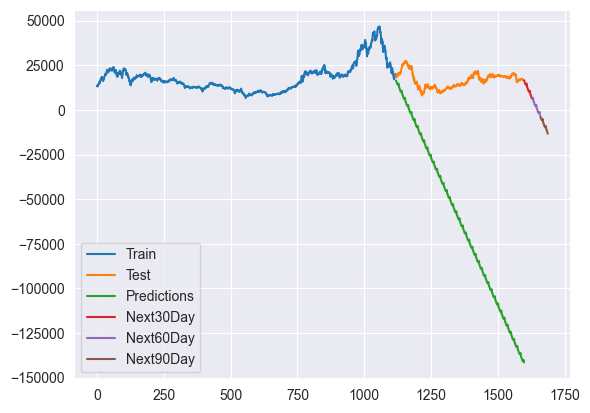

In [17]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data1,y_next_90_days[0:30])
plt.plot(last_data2,y_next_90_days[31:60])
plt.plot(last_data3,y_next_90_days[61:90])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

In [18]:
def tes_optimizer(train, test, abg, trend, seasonal, seasonal_periods, step):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        try:
            tes_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).\
                fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
            y_pred = tes_model.forecast(step)
            if np.isnan(y_pred).any():
                continue  # Skip this combination if y_pred contains NaN values
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        except ValueError as e:
            if "strictly positive" in str(e):
                continue  # Skip this combination if the error is due to non-positive values
            else:
                raise e

    return best_alpha, best_beta, best_gamma, best_mae


alphas = betas = gammas = np.arange(0.10, 1, 0.10)
abg = list(itertools.product(alphas, betas, gammas))
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(x_train, x_test, abg=abg, trend='mul', seasonal='mul', seasonal_periods=12, step=480)
final_model = ExponentialSmoothing(y_train, trend='mul', seasonal='mul', seasonal_periods=12).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
y_pred = final_model.forecast(480)


In [19]:
# 6. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data2 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data3 = pd.RangeIndex(start=last_index+61, stop=last_index+90, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

y_next_90_days = final_model.forecast(len(x_next_90_days))
y_next_90_days



array([19789.48723721, 19905.5452891 , 20079.80562538, 19918.81375197,
       19588.00342365, 19540.06750649, 19525.2016984 , 19383.86296805,
       19210.71509326, 19130.40531368, 18989.48964025, 18508.77278596,
       18230.87504679, 18337.7924124 , 18498.32807349, 18350.01585638,
       18045.26001872, 18001.09951545, 17987.40453252, 17857.19758469,
       17697.68676806, 17623.70215497, 17493.88494426, 17051.02915935,
       16795.01853624, 16893.51513241, 17041.40706831, 16904.77586277,
       16624.0224744 , 16583.3400349 , 16570.72366341, 16450.77176332,
       16303.82395553, 16235.66634131, 16116.07348279, 15708.0968444 ,
       15472.24951675, 15562.98855995, 15699.23258545, 15573.36239964,
       15314.72103713, 15277.24273048, 15265.62001942, 15155.11548355,
       15019.74122701, 14956.95167954, 14846.77790727, 14470.93334762,
       14253.66126224, 14337.25373427, 14462.76723419, 14346.81053446,
       14108.53966339, 14074.01313336, 14063.30582242, 13961.50458011,
      

In [20]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 10760.862370045803
RMSE: 12282.007060543996
MAPE: 0.6269303633846939


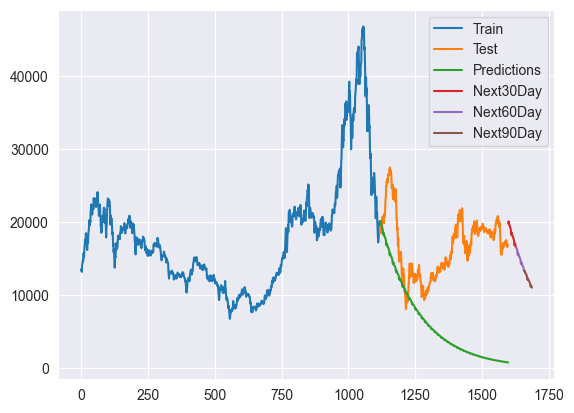

In [21]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data1,y_next_90_days[0:30])
plt.plot(last_data2,y_next_90_days[31:60])
plt.plot(last_data3,y_next_90_days[61:90])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

In [22]:
alphas = betas = gammas = np.arange(0.10, 1, 0.10)
abg = list(itertools.product(alphas, betas, gammas))
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(x_train, x_test, abg=abg, trend='mul', seasonal='add', seasonal_periods=12, step=480)
final_model = ExponentialSmoothing(y_train, trend='mul', seasonal='add', seasonal_periods=12).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
y_pred = final_model.forecast(480)


In [23]:
# 6. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data2 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data3 = pd.RangeIndex(start=last_index+61, stop=last_index+90, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

y_next_90_days = final_model.forecast(len(x_next_90_days))
y_next_90_days



array([19758.33924517, 19926.88999928, 20243.9997765 , 20080.89650997,
       19637.19181168, 19542.71659999, 19434.84962664, 19314.19032997,
       19106.37894607, 19111.37649482, 19034.25842564, 18485.66568276,
       18165.87522434, 18345.20020253, 18673.01130804, 18520.53696723,
       18087.38928193, 18003.39965705, 17905.94732757, 17795.63221184,
       17598.09502266, 17613.29725343, 17546.31482387, 17007.78914534,
       16697.99763997, 16887.25392072, 17224.92913601, 17082.25216682,
       16658.83556651, 16584.51118846, 16496.65871311, 16395.87850122,
       16207.81170505, 16232.42025445, 16174.78050266, 15645.53429162,
       15344.95947111, 15543.37007888, 15890.13768525, 15756.49159022,
       15342.04476337, 15276.62947149, 15197.62580559, 15105.63453427,
       14926.29721482, 14959.57617944, 14910.54818094, 14389.85545816,
       14097.77625511, 14304.62500104, 14659.77365519, 14534.4519038 ,
       14128.27310012, 14071.06989196, 14000.22274884, 13916.33281523,
      

In [24]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 10821.445712222516
RMSE: 12353.351965868673
MAPE: 0.6306290619506136


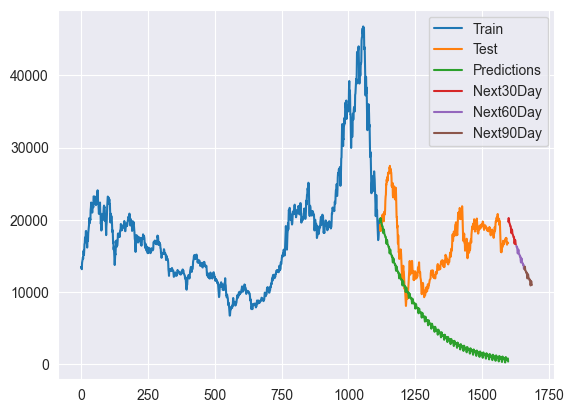

In [25]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data1,y_next_90_days[0:30])
plt.plot(last_data2,y_next_90_days[31:60])
plt.plot(last_data3,y_next_90_days[61:90])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

In [26]:
alphas = betas = gammas = np.arange(0.10, 1, 0.10)
abg = list(itertools.product(alphas, betas, gammas))
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(x_train, x_test, abg=abg, trend='add', seasonal='mul', seasonal_periods=12, step=480)
final_model = ExponentialSmoothing(y_train, trend='add', seasonal='mul', seasonal_periods=12).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
y_pred = final_model.forecast(480)


In [27]:
# 6. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data2 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data3 = pd.RangeIndex(start=last_index+61, stop=last_index+90, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

y_next_90_days = final_model.forecast(len(x_next_90_days))
y_next_90_days



array([19709.78824026, 19747.0187756 , 19837.39923777, 19597.1535732 ,
       19190.28654257, 19058.92428775, 18957.53623066, 18730.09428034,
       18473.02885388, 18302.8164437 , 18074.71966334, 17519.62119339,
       17163.00114212, 17167.64663837, 17217.70598489, 16980.389638  ,
       16599.01677918, 16456.10411165, 16338.75910567, 16112.60430595,
       15861.0449581 , 15684.04296807, 15457.37480338, 14951.67035259,
       14616.21404399, 14588.27450114, 14598.012732  , 14363.6257028 ,
       14007.74701579, 13853.28393555, 13719.98198068, 13495.11433157,
       13249.06106233, 13065.26949245, 12840.02994342, 12383.71951178,
       12069.42694586, 12008.90236391, 11978.31947911, 11746.86176759,
       11416.4772524 , 11250.46375946, 11101.20485569, 10877.62435719,
       10637.07716656, 10446.49601682, 10222.68508346,  9815.76867098,
        9522.63984773,  9429.53022668,  9358.62622622,  9130.09783239,
        8825.20748901,  8647.64358336,  8482.4277307 ,  8260.1343828 ,
      

In [28]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 48431.54462035059
RMSE: 57295.290637364735
MAPE: 2.920044577620587


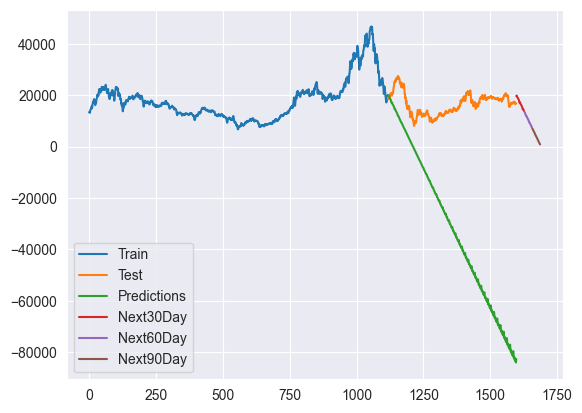

In [29]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data1,y_next_90_days[0:30])
plt.plot(last_data2,y_next_90_days[31:60])
plt.plot(last_data3,y_next_90_days[61:90])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

## Observation:
-  Triple Exponential Smoothing with both multiplicative trend and seasonality  acchieve the best MAE, RMSE, MAPE score  -> choose the model